# Simulating and Visualization Magic State Distillation (MSD)

*Yunzhe Zheng, for course project of APHY 526 (2024 Fall)*

## Why do we need MSD?
Quantum computers are regarded as promising platform to outperform classical computers on certain problems. However, real-world quantum computers are subject to various kind of quantum noise that could decohere quantum information and prevent us from gaining quantum advantages. Therefore, quantum computers must be made fault-tolerant in order to obtain robustness to quantum noise, and we need Quantum Error Correcting (QEC) codes to preserve quantum information in the logical qubits.

Although QEC codes allow to preserve quantum information in a fault-tolerant way, we would usually more like to process quantum information rather than just keep it in stationary memories. The quantum operation, surely, should also be fault-tolerant to avoid undesirable error propagation between different subsystems. A natural way to process quantum information is the so-called *transversal* operations, which means the logical operations are implemented by the physical operations implemeneted on each subsystem. For example, a logical CNOT gate between two logical qubits can be implemented by pair-wise physical CNOT gates between these two blocks:
<p align="center">
<img src="img/transversal.png" alt="drawing" width="200"/>
</p>

Transversality grants fault-tolerance naturally, as there won't be correlated errors cascaded from single local error. However, transversality is a too good property to be the golden solution for QEC. In 2009, Eastin and Knill proposed a no-go theorem, showing that no transversal gate sets can achieve universality in any QEC codes. Universal gate sets mean that we can implement arbitrary quantum computation with gates from the given gate sets, and universality has been considered to be a necessity for realistic quantum advantage. 

Clifford gates are these gate that maps Pauli operators to Pauli operators, and they can be generated by gate set $\{H, S, CNOT\}$. In many common codes, Clifford gate sets are transversal. Nevertheless, quantum circuits composed of only Clifford gates are also proved to be efficiently simulable with classical computers and bring no quantum advantages. Because of the no-go theorem, we therefore believe the non-Clifford resources are the *magic* ingredient from classical regime to quantum advantage.

Due to the fact that non-Clifford gates cannot be implemented transverally simultaneously with the Clifford gates, we usually believe that we must suffer a certain amount of noise when we apply logical non-Clifford gates. To circumvent this case, Bravyi and Kitaev proposed the *Magic State Distillation (MSD)* in 2005, which transfer the overhead for implementing high-quality non-Clifford gates to preparing high-fidelity non-Clifford states (or magic states) with a technique called gate injection. By consuming a high-fidelity copy of non-Clifford resource state, we can implemented a $T$ gate on the quantum circuit with only fault-tolerant operations.
<p align="center">
<img src="img/gate_injection.png" alt="drawing" width="400"/>
</p>

Therefore, as long as we have access to the high-fidelity magic states, we can achieve universal quantum computation together with fault-tolerant Clifford operations.



## What is MSD?
In MSD, we often start with a stable supply of moderate-fidelity magic states. We are aim to "distill" these raw states into higher fidelity states with only Clifford operations, measurements and classical processing. The process can somehow be regarded as an error-correcting process, but not exactly the same. Most MSD protocols can be described by stabilizer codes, and I will start by introducing the $[[5, 1, 3]]$ codes to show how we distill a faulty magic state into a better one.


### [[5, 1, 3]] MSD protocols

First, let us import some necessary modules. The `qiskit.quantum_info` module is a powerful module for analytically simulating quantum systems. We need `numpy` and `matplotlib.pyplot` as well for basic math and visualization.

In [2]:
from qiskit import quantum_info as qi
import numpy as np
from matplotlib import pyplot as plt

The $[[5, 1, 3]]$ quantum code can be described by four stabilizer generators:

$$
S_1 = XZZXI, S_2 = IXZZX, S_3 = XIXZZ, S_4 = ZXIXZ.
$$
You might already noticed that $S_{2,3,4}$ can be obtained by cylic-shifting the qubit index in $S_1$. Actually, we can even shift more and have $S_5 = ZZXIX$. However, $S_5$ is not an independent stabilizer element as it can be described by
$$
S_5 = S_1S_2S_3S_4.
$$
Therefore, for full description of the code, four of the five cyclic symmetric elements will be sufficient.

Besides, the logical operators for the code can be defined by
$$
X_L = XXXXX, Z_L = ZZZZZ.
$$

Now, let's put the code description down. Thanks to `Pauli` in `qiskit.quantum_info`, we only need to input the Pauli strings.

In [3]:
generator_set = ['XZZXI', 'IXZZX', 'XIXZZ', 'ZXIXZ']
generator_set = [qi.Pauli(ele) for ele in generator_set]
logical_operator = {"X": "XXXXX", "Z": "ZZZZZ"}
logical_X = logical_operator['X']
logical_Z = logical_operator['Z']

We got the code! But how to distill magic states from it? As mentioned in this [paper](http://arxiv.org/abs/0908.0838), we must consider the stabilizer reduction protocols for MSD protocols. We need to define the codespace projector first. For stabilizer code $\mathcal{Q}$, the codespace projector is given by
$$
\bar{P} = \prod^{n-k}_{i=1}\frac{I+g_i}{2}.
$$

For the $[[5, 1, 3]]$ code, we have four generators. we can then calculate the codespace projector:

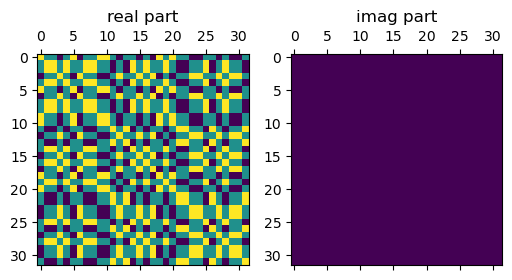

In [ ]:
P_bar = np.eye(2**5)

for g in generator_set:
    P_bar = P_bar @ (g.to_matrix() + qi.Pauli('IIIII').to_matrix())/2

fig, axs = plt.subplots(1,2, figsize=(6,3))
axs[0].matshow(P_bar.real)
axs[0].set_title('real part')
axs[1].matshow(P_bar.imag)
axs[1].set_title('imag part')


As we can see, the $\bar P$ is a full real matrix, which makes sense as a property for being a projector. We can further calculate the logical zero and logical one state by 

$$
\ket{0_L}\bra{0_L} = \frac{I+Z_L}{2}\bar{P}, \quad \ket{1_L} = X_L\ket{0_L}.
$$

We can use the build-in function `to_statevector` in `quantum_info` to get the statevector from density matrix.

In [ ]:
logical_zero = qi.DensityMatrix(P_bar @ (qi.Pauli('IIIII').to_matrix() + qi.Pauli('ZZZZZ').to_matrix())/2).to_statevector()
logical_one = logical_zero.evolve(qi.Pauli('XXXXX'))

Finally, let's think about distillation! The magic state to be distilled is given by $\rho_{ideal} = (I+(X+Y+Z)/\sqrt{3})/2$. We consider the fully depolarizing noise model, where our raw input state is 

$$
\rho(\epsilon) = (1-2\epsilon)\rho_{ideal} + \epsilon I.
$$


In [25]:
rho_ideal = 0.5 * (qi.Pauli('I').to_matrix() + ( qi.Pauli('X').to_matrix() + qi.Pauli('Y').to_matrix() + qi.Pauli('Z').to_matrix())/np.sqrt(3) ) 

def get_single_rho(epsilon):
    return (1-2*epsilon)*rho_ideal + epsilon*np.eye(2)

The whole input state will be a tensor product of five single qubit state: $\rho_{in}=\rho(\epsilon)^{\otimes 5}$. The distillation is effectively to project the input state onto the codespace with the code projector $\bar{P}$:
$$
\rho_p \propto \bar{P} \rho_{in} \bar{P}
$$
and then decode with logical operators $X_L$ and $Z_L$. The output state will be
$$
\rho_o = (I+xX+yY+zZ)/2,
$$
with
$$
x = Tr [\bar{P}X_L \rho_p], \quad y = Tr [\bar{P}Y_L \rho_p], z = Tr [\bar{P}Z_L \rho_p]
$$

In [26]:
def projection(rho_input):
    p_suc = np.trace(P_bar @ rho_input)
    x = -np.trace(P_bar @ qi.Pauli(logical_operator['X']).to_matrix() @ rho_input)/p_suc
    y = np.trace(P_bar @ qi.Pauli(logical_operator['Z']).to_matrix() @ qi.Pauli(logical_operator['X']).to_matrix() @ rho_input * 1j)/p_suc
    z = -np.trace(P_bar @ qi.Pauli(logical_operator['Z']).to_matrix() @ rho_input)/p_suc
    #print(x, y, z)
    rho_output = 0.5 * (qi.Pauli('I').to_matrix() +  x*qi.Pauli('X').to_matrix() + y*qi.Pauli('Y').to_matrix() + z*qi.Pauli('Z').to_matrix() )
    fidelity = qi.state_fidelity(rho_output, rho_ideal)

    return p_suc, fidelity

In [27]:
e_list = np.arange(0,.5,.01)
e_out = []
for e in e_list:
    rho_single = get_single_rho(e)
    rho_five = rho_single
    for _ in range(4):
        rho_five = np.kron(rho_five, rho_single)
    p_suc, fidelity = projection(rho_five)
    e_out.append(1-fidelity)

Text(0, 0.5, 'output error')

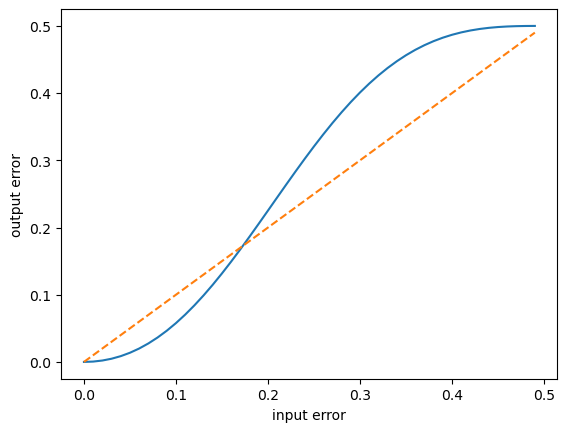

In [28]:
plt.plot(e_list,e_out)
plt.plot(e_list,e_list,'--')
plt.xlabel('input error')
plt.ylabel('output error')

Good! We have successfully simulated the MSD protocols based on $[[5, 1, 3]]$ code. Actually, this figure is exactly the same as the result in the first very paper back in 2005 [here](https://journals.aps.org/pra/pdf/10.1103/PhysRevA.71.022316).